# Import & load data

In [57]:
import pandas as pd
import csv
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

import dedupe
from unidecode import unidecode

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.3f}'.format


In [34]:
def preProcess(column):
    """
    Do a little bit of data cleaning with the help of Unidecode and Regex.
    Things like casing, extra spaces, quotes and new lines can be ignored.
    """
    column = unidecode(column)
    column = re.sub("  +", " ", column)
    column = re.sub("\n", " ", column)
    column = column.strip().strip('"').strip("'").lower().strip()
    # If data is missing, indicate that by setting the value to `None`
    if not column:
        column = None
    return column

def readData(filename):
#
    data_d = {}
    with open(filename) as f:
        reader = csv.DictReader(f)
        for row in reader:
            clean_row = [(k, preProcess(v)) for (k, v) in row.items()]
            row_id = str(row["ID"])
            data_d[row_id] = dict(clean_row)

    return data_d

In [2]:
path = '/home/yannick/Documents/GIP/data/'
input_file = path+'structures_data_inclusion_ft.csv'
output_file = path+"structures_data_inclusion_ft_output.csv"
settings_file = path+"structures_data_inclusion_ft_learned_settings"
training_file = path+"structures_data_inclusion_ft_training.json"

In [36]:
print("importing data ...")
data_d = readData(input_file)

importing data ...


In [39]:
if os.path.exists(settings_file):
    print("reading from", settings_file)
    with open(settings_file, "rb") as f:
        deduper = dedupe.StaticDedupe(f)
else:
    # ## Training

    # Define the fields dedupe will pay attention to
    fields = [
        dedupe.variables.String("Nom"),
        dedupe.variables.Exact("Code Postal"),
        dedupe.variables.Exact("Code Insee"),
        dedupe.variables.String("Commune", has_missing=True),
        dedupe.variables.String("Adresse", has_missing=True),
        dedupe.variables.Exact("Siret",has_missing=True),
        #dedupe.variables.String("Telephone", has_missing=True), #not useful for FT
        #dedupe.variables.String("Courriel", has_missing=True),
    ]

    # Create a new deduper object and pass our data model to it.
    deduper = dedupe.Dedupe(fields)

    # If we have training data saved from a previous run of dedupe,
    # look for it and load it in
    if os.path.exists(training_file):
        print("reading labeled examples from ", training_file)
        with open(training_file, "rb") as f:
            deduper.prepare_training(data_d, f)
    else:
        deduper.prepare_training(data_d)

In [41]:
print("starting active labeling...")

dedupe.console_label(deduper)

# Using the examples we just labeled, train the deduper and learn
# blocking predicates
deduper.train()

Nom : agence france travail macon
Code Postal : 71000.0
Code Insee : 71270
Commune : macon
Adresse : 1000 avenue marechal de lattre de tassigny
Siret : 13000548102826.0

Nom : agence france travail macon
Code Postal : 71000.0
Code Insee : 71270
Commune : macon
Adresse : 1000 avenue marechal de lattre de tassigny
Siret : 13000548102826.0

0/10 positive, 0/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished


starting active labeling...


Nom : agence france travail noisy-le-grand
Code Postal : 93160.0
Code Insee : 93051
Commune : noisy-le-grand
Adresse : 8 rue du marechal juin
Siret : 13000548108211.0

Nom : agence france travail sete
Code Postal : 34200.0
Code Insee : 34301
Commune : sete
Adresse : 220 avenue du marechal juin
Siret : 13000548123558.0

1/10 positive, 0/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious
Nom : france travail plateforme de production
Code Postal : 97300.0
Code Insee : 97302
Commune : cayenne
Adresse : 48 avenue louis pasteur
Siret : 13000548109847.0

Nom : france travail direction regionale guyane
Code Postal : 97300.0
Code Insee : 97302
Commune : cayenne
Adresse : 19 avenue louis pasteur
Siret : 13000548117345.0

1/10 positive, 1/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious
Nom : agence france travail st etienne technopole
Code Postal : 42000.0
Code Insee : 42218
Commune : sain

In [42]:
# When finished, save our training to disk
with open(training_file, "w") as tf:
    deduper.write_training(tf)

# Save our weights and predicates to disk.  If the settings file
# exists, we will skip all the training and learning next time we run
# this file.
with open(settings_file, "wb") as sf:
    deduper.write_settings(sf)

In [43]:
print("clustering...")
clustered_dupes = deduper.partition(data_d, 0.5)

print("# duplicate sets", len(clustered_dupes))

clustering...
# duplicate sets 989


In [44]:
# Write our original data back out to a CSV with a new column called
# 'Cluster ID' which indicates which records refer to each other.

cluster_membership = {}
for cluster_id, (records, scores) in enumerate(clustered_dupes):
    for record_id, score in zip(records, scores):
        cluster_membership[record_id] = {
            "Cluster ID": cluster_id,
            "confidence_score": score,
        }

with open(output_file, "w") as f_output, open(input_file) as f_input:

    reader = csv.DictReader(f_input)
    fieldnames = ["Cluster ID", "confidence_score"] + reader.fieldnames

    writer = csv.DictWriter(f_output, fieldnames=fieldnames)
    writer.writeheader()

    for row in reader:
        row_id = str(row["ID"])
        row.update(cluster_membership[row_id])
        writer.writerow(row)

In [3]:
df = pd.read_csv(output_file)

In [64]:
df[df['Nom'] == 'Agence France Travail CROIX'].sort_values(by='Cluster ID')

,Cluster ID,confidence_score,Di Surrogate ID,Di Geocodage Score,ID,Siret,Rna,Nom,Commune,Code Postal,...,Presentation Detail,Source,Date Maj,Antenne,Lien Source,Horaires Ouverture,Accessibilite,Labels Nationaux,Labels Autres,Thematiques
47,140,0.641,dora-664367c2-0017-4a0b-89cd-a7fda489534e,1.000,664367c2-0017-4a0b-89cd-a7fda489534e,13000548123129.000,NaN,Agence France Travail CROIX,Croix,59170.000,...,France Travail est l’opérateur public de référ...,dora,"janvier 22, 2024",False,https://dora.inclusion.beta.gouv.fr/structures...,NaN,NaN,{france-travail},{},NaN
1292,140,0.641,france-travail-HDF0040,1.000,HDF0040,13000548123129.000,NaN,Agence France Travail CROIX,Croix,59170.000,...,NaN,france-travail,"septembre 10, 2024",False,NaN,Mo 08:30-12:45;Tu 08:30-12:45;We 08:30-12:45;T...,https://www.pole-emploi.fr/actualites/a-laffic...,{france-travail},NaN,NaN


In [47]:
df[['Cluster ID','Nom','Commune','Adresse','Code Postal','Siret']].sort_values(by='Cluster ID')

,Cluster ID,Nom,Commune,Adresse,Code Postal,Siret
600,0,Relai France Travail SAINT JULIEN EN GENEVOIS,Saint-Julien-en-Genevois,26 Avenue de geneve,74160,13000548119754
713,0,Relai France Travail SAINT JULIEN EN GENEVOIS,Saint-Julien-en-Genevois,26 Avenue de geneve,74160,13000548119754
233,1,Agence France Travail DRAGUIGNAN,Draguignan,105 PLACE DU 7E BATAILLON DE CHASSEURS ALPINS,83300,13000548124796
1600,1,Agence France Travail DRAGUIGNAN,Draguignan,105 PLACE DU 7E BATAILLON DE CHASSEURS ALPINS,83300,13000548124796
926,2,Agence France Travail ST LOUIS BEL AIR,Saint-Louis,20 Rue de l'Étang,97450,13000548119093
...,...,...,...,...,...,...
97,984,DT VALLEE DE LA LOIRE,Saint-Pierre-des-Corps,55 Avenue Georges Pompidou,37700,NaN
1,985,Agence France Travail SAINT-MEDARD-EN-JALLES,Saint-Médard-en-Jalles,59 Rue Jean Duperrier,33160,13000548126569
691,986,Agence France Travail FIGEAC,Figeac,8bis Avenue Joseph Loubet,46100,13000548129016
731,987,France Travail DT JURA HAUTE-SAONE,Dole,12 Avenue Aristide Briand,39100,13000548125926


In [4]:
df_duplicated = df[df.duplicated(subset=['Cluster ID'],keep=False)]
df_unique = df.drop_duplicates(subset=['Cluster ID'],keep=False)


# Histogram and stuff

In [12]:
df_dup_hist = df_duplicated.drop_duplicates(subset=['Cluster ID'])

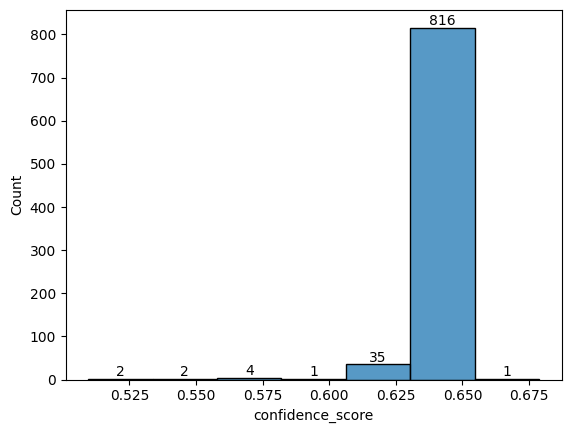

In [66]:
ax = sns.histplot(data = df_dup_hist['confidence_score'],bins=7)

for patch in ax.patches:
    height = patch.get_height()
    ax.annotate(f'{int(height)}', 
                (patch.get_x() + patch.get_width() / 2, height), 
                ha='center', va='bottom')
    
plt.show()

In [61]:
low_confidence = df_duplicated[df_duplicated['confidence_score'] < 0.6].sort_values(by='Cluster ID')

In [63]:
list_low_conf = []
for i in low_confidence['Nom'].unique():
    df_ = df_duplicated[['Cluster ID','confidence_score','Nom','Siret','Adresse']][df_duplicated['Nom']==i]
    list_low_conf.append(df_)
    

In [65]:
df_low_conf = pd.concat(list_low_conf)
df_low_conf

,Cluster ID,confidence_score,Nom,Siret,Adresse
758,69,0.548,Agence France Travail ALBI,13000548100705.000,Avenue Pierre-Gilles de Gennes
1106,69,0.548,Agence France Travail ALBI,13000548126940.000,37 Avenue Pierre-Gilles de Gennes
502,137,0.571,Agence France Travail Paris 7 8 9ème St Peters...,13000548121784.000,34 Rue de Saint-Pétersbourg
657,137,0.571,Agence France Travail Paris 7 8 9ème St Peters...,13000548121784.000,34 RUE Saint Petersbourg
826,167,0.580,Agence France Travail CHALON CENTRE,13000548117238.000,27 Avenue Georges Pompidou
1678,167,0.580,Agence France Travail CHALON CENTRE,13000548105167.000,27 Avenue Georges Pompidou
516,221,0.573,Agence spécialisée France Travail Cinéma Spect...,13000548122915.000,202 Rue de la Croix Nivert
1851,221,0.583,Agence spécialisée France Travail Cinéma Spect...,13000548122915.000,202 RUE DE LA CROIX NIVERT
711,221,0.537,Agence spécialisée France Travail Agence Spect...,13000548122915.000,202 RUE DE LA CROIX NIVERT
1121,248,0.584,Agence France Travail LA CIOTAT,13000548124416.000,196 Avenue Emile Sellon


In [56]:
df[['Nom','Siret','Adresse']][df['Cluster ID']==760]

,Nom,Siret,Adresse
810,Agence France Travail PERIGUEUX LITTRE,13000548107114.000,134 Avenue Marechal Juin
1001,Agence France Travail PERIGUEUX,13000548126718.000,134 Avenue Marechal Juin
1335,Agence France Travail PERIGUEUX,13000548126718.000,134 Avenue Marechal Juin
